# Импортируем библиотеки

In [42]:
import numpy as np
import pandas as pd
import re
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

plt.style.use('seaborn') 
sns.set_style("whitegrid")

# Выгружаем данные 

In [2]:
train_df = pd.read_excel('train.xlsx')
test_df = pd.read_excel('test.xlsx')

In [3]:
train_df.head(3)

,text,target
0,"Здравствуйте, как поменять пароль на самом Wi-Fi",2
1,У меня 2 день нет интернета,0
2,Можно узнать почему скачит пинг в игре?,6


In [4]:
test_df.head(3)

,id,text
0,0,Как поставить пароль на вай-фай
1,1,Почему низкая скорость интернета?
2,2,"Здравствуйте. Это просто не выносимо, каждый д..."


# Анализ данных 

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2442 entries, 0 to 2441
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2442 non-null   object
 1   target  2442 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.3+ KB


### Посмотрим примеры обращений клиентов

In [6]:
pd.set_option('display.max_colwidth', None)

for i in range(11):
    print(f'Target: {i}')  
    subset = train_df[train_df['target'] == i].iloc[:3]['text']
    
    for idx, text in enumerate(subset, 1):
        print(f'{idx}. {text}')
    print('-' * 40) 
    print('\n')

Target: 0
1. У меня 2 день нет интернета
2. Почему у меня интернет не работает ?
3. Здравствуйте, подскажите, куда делся интернет и ТВ?
----------------------------------------


Target: 1
1. Здравствуйте.  В недавнее время проводились какие то работы в поселке во время которых были перебои с доступом. А после них.  Значительно упала скорость соединения.  Соединение не стабильное.
2. Здравствуйте!!! У меня три дня уже интернет плохо работает, скорость маленький, 1,63. Нужна ваша помощь
3. почему такая скорость?
----------------------------------------


Target: 2
1. Здравствуйте, как поменять пароль на самом Wi-Fi
2. Дд! Как сменить пароль от вай фай?
3. Я б хотела заменить пароль от вай Фая
----------------------------------------


Target: 3
1. Здравствуйте. Перегнулся оптоволоконный кабель. Как вызвать специалиста на дом ? Платная ли эта услуга?
2. Здравствуйте, у нас собака перегрызла провод интернет и сломался роутер, как нам поступить какие есть варианты?
3. Добрый вечер. Как пом

In [7]:
def plot_category_counts(df, column_name):
    
    category_counts = df[column_name].value_counts()

    plt.figure(figsize=(16, 6))
    bars = category_counts.plot(kind="bar")
    
    plt.title(f'Количество объектов для каждой категории признака {column_name}')
    plt.xlabel('Категория')
    plt.ylabel('Количество обращений')
    plt.xticks(rotation=0)

#     plt.grid(axis="y", linestyle="--")

    # Добавление текста с количеством объектов над каждой колонкой
    for bar in bars.patches:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.1,
            int(bar.get_height()),
            ha='center',
            va='bottom',
        )

    plt.show()

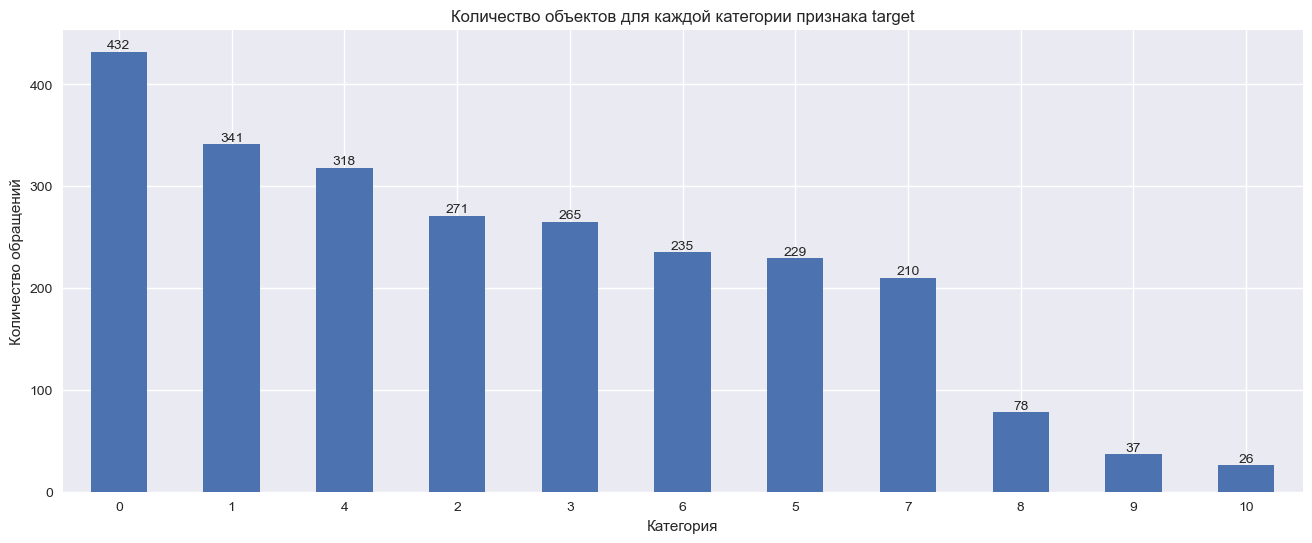

In [8]:
plot_category_counts(train_df, 'target')

Виден дисбаланс классов. 

***Наиболее часто*** встречаются запросы связанные с **проблемой с доступом в интернет**.

***Менее часто*** встречаются обращения связанные с **оборудованием и его установкой**.

### Оценим распределение длин текстов в символах

In [9]:
sns.set_style("whitegrid")

In [10]:
def plot_review_length_distribution(df, review_column):
    # Вычисляем длины текстов в указанной колонке
    review_lengths = df[review_column].apply(len)

    # Строим гистограмму распределения длин текстов
    plt.figure(figsize=(10, 6))
    sns.histplot(review_lengths, bins=40, edgecolor="black")
    plt.title("Распределение длин текстов по символам")
    plt.xlabel("Длина текста (в символах)")
    plt.ylabel("Количество обзоров")
    plt.show()

In [11]:
def plot_review_word_count_distribution(df, review_column):
    # Вычисляем количество слов в указанной колонке
    word_counts = df[review_column].apply(lambda x: len(x.split()))

    # Строим гистограмму распределения количества слов
    plt.figure(figsize=(10, 6))
    sns.histplot(word_counts, bins=40, edgecolor="black")
    plt.title("Распределение длин текстов по количеству слов")
    plt.xlabel("Количество слов")
    plt.ylabel("Количество обзоров")
    plt.show()

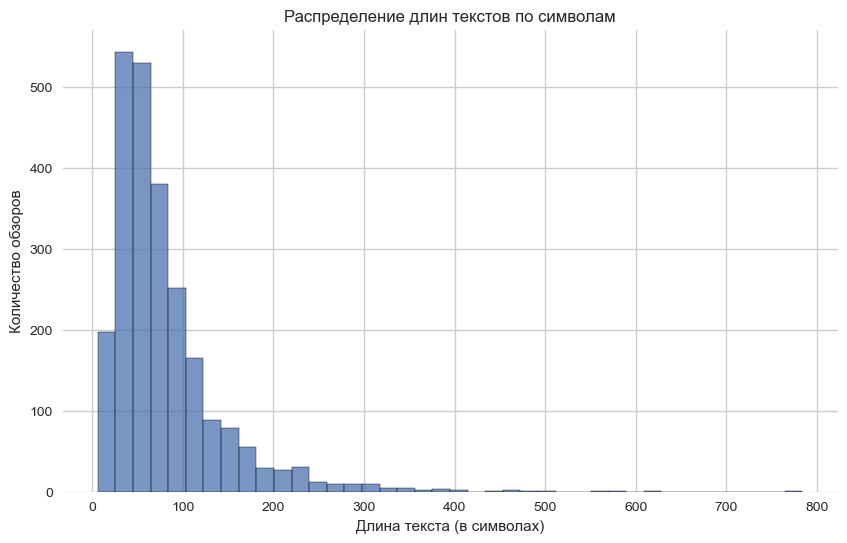

In [12]:
plot_review_length_distribution(train_df, 'text')

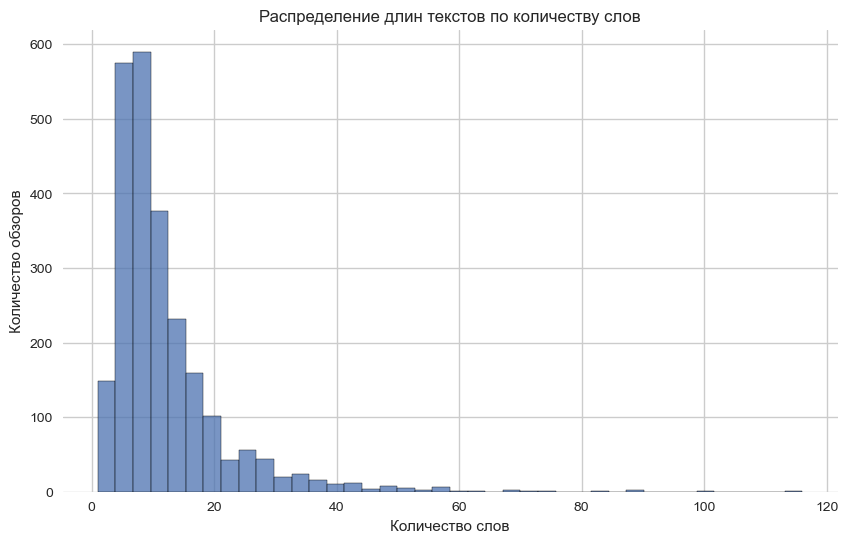

In [13]:
plot_review_word_count_distribution(train_df, 'text')

Большинство отзывов не превышают 200 символов и 30 слов. Имеются выбросы.

### Выводы


Проблема: опечатки


# Модель

In [27]:
X = train_df['text']
y = train_df['target']

In [35]:
# Делиим обучающую выборку на train/test и указываем stratify=y, для равномерного распределения значений таргета между выборками
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


451                                                                                                                           Что опять  с интернетом? Где скорость ?
2148                                                                                                                                    Как сменить пароль,от Wi-fi?)
1736                                                                                                       Отключается интернет на некоторое время, потом появляется.
2041                                                                                           Здравствуйте. У меня положительный баланс, но подключение отсутствует.
1529                                                                               Здравствуйте, проблема с интернетом, в онлайн играх пропадает интернет,пинг падает
                                                                                    ...                                                                              
556 

In [37]:
from sklearn.neighbors import KNeighborsClassifier

import nltk
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec

In [15]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nik_p\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
train_sentences = train_df['text'].values.tolist()

tokenized_sentences_train = [word_tokenize(sentence.lower()) for sentence in train_sentences]

In [17]:
tokenized_sentences_train

[['здравствуйте', ',', 'как', 'поменять', 'пароль', 'на', 'самом', 'wi-fi'],
 ['у', 'меня', '2', 'день', 'нет', 'интернета'],
 ['можно', 'узнать', 'почему', 'скачит', 'пинг', 'в', 'игре', '?'],
 ['здравствуйте',
  ',',
  'стал',
  'плохо',
  'работать',
  'интернет',
  'роутер',
  ',',
  'можно',
  'мне',
  'его',
  'заменить',
  '?'],
 ['здравствуйте',
  '!',
  'обрывы',
  'постоянные',
  '.',
  'просмотр',
  'фильмов',
  'онлайн',
  '(',
  'у',
  'нас',
  'подключен',
  'ivi',
  ')',
  'прерывается',
  'сообщеним',
  '«',
  'нет',
  'соединения',
  'с',
  'интернет',
  '»',
  '.',
  'из',
  'zoom',
  'конференции',
  'выкидывает'],
 ['здравствуйте',
  '.',
  'в',
  'недавнее',
  'время',
  'проводились',
  'какие',
  'то',
  'работы',
  'в',
  'поселке',
  'во',
  'время',
  'которых',
  'были',
  'перебои',
  'с',
  'доступом',
  '.',
  'а',
  'после',
  'них',
  '.',
  'значительно',
  'упала',
  'скорость',
  'соединения',
  '.',
  'соединение',
  'не',
  'стабильное',
  '.'],
 ['

In [18]:
model = Word2Vec(tokenized_sentences_train, vector_size=100, window=5, min_count=1, workers=4)


In [19]:
vector = model.wv['роутер']
print(f'Вектор для слова "machine":\n{vector}')

Вектор для слова "machine":
[-0.20314258  0.6495585   0.10374341  0.1252997   0.10571264 -0.88602287
  0.5869604   1.1627384  -0.63572204 -0.51511353 -0.1678842  -0.9352317
  0.1370246   0.178324    0.319169   -0.44323093  0.33952728 -0.5950593
 -0.12688264 -1.4896111   0.16244666  0.3660813   0.45723718 -0.34622037
 -0.2392715   0.12838887 -0.4907508  -0.44225127 -0.39553732  0.09350833
  0.57355136 -0.04312189  0.43253917 -0.6569173  -0.35847032  0.65334415
  0.13773347 -0.33864376 -0.3613377  -1.2148198  -0.04054299 -0.5265156
 -0.33899885 -0.01099552  0.4816304  -0.2919244  -0.556667   -0.2913123
  0.27887633  0.2926913   0.07175873 -0.58958673 -0.20180875 -0.05241513
 -0.08638881  0.13288905  0.28122774 -0.17345223 -0.69219387  0.34906158
  0.02570482 -0.07566737  0.24436893 -0.17252907 -0.61088425  0.82567376
  0.02935885  0.6607962  -1.0241739   0.70868886 -0.27144438  0.4937804
  0.8932082   0.00410125  0.5139545   0.17036329 -0.18648572 -0.02549996
 -0.5844691  -0.03554175 -0.

In [20]:
vector = model.wv['роутэр']
print(f'Вектор для слова "machine":\n{vector}')

Вектор для слова "machine":
[ 4.10120981e-03  1.21094929e-02 -3.64838727e-03  1.10589536e-02
 -2.48656521e-04 -8.13469198e-03  4.85107535e-04  1.93379186e-02
 -1.92055162e-02 -7.00101256e-03 -2.21461851e-05 -1.10839074e-02
  2.25221226e-03 -6.37761783e-03  8.42290185e-03 -1.46442966e-03
  1.27272145e-03 -4.36693290e-03 -6.61566202e-03 -2.56248191e-02
  3.04324483e-03  1.10425204e-02  1.63847040e-02 -8.71627219e-03
 -2.38679955e-03  1.19988411e-03 -5.01612434e-03 -1.64678898e-02
 -9.60665382e-03 -4.69480059e-04  9.27638169e-03 -4.82670404e-03
  6.33971021e-03 -2.14168127e-03 -1.24930777e-02  1.62249408e-03
  8.30450654e-03  2.12820666e-03 -6.01018034e-03 -3.07070278e-02
 -6.93471823e-03 -1.50578972e-02 -2.99039483e-03  7.83815514e-03
  1.54366950e-02  2.98665208e-03 -3.16302618e-03 -9.07413720e-04
  1.11911269e-02  1.44737875e-02 -6.78741699e-03 -1.19403880e-02
  5.19248890e-03  5.52869355e-03 -2.06239196e-03 -6.57612924e-03
  1.49050402e-02 -2.24203710e-03 -3.26954364e-03  7.71915214e-

In [21]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics.pairwise import cosine_similarity


In [22]:
cosine_similarity(model.wv['роутэр'].reshape(1, -1), model.wv['роутер'].reshape(1, -1))

array([[0.82712024]], dtype=float32)

In [51]:
# Пример двух векторов в виде массива
vector_1 = np.array([[1, 2, 3]])
vector_2 = np.array([[4, 5, 6]])

# Вычисление косинусной близости
similarity = cosine_similarity(vector_1, vector_2)
print(f"Косинусная близость: {similarity[0][0]}")

Косинусная близость: 0.9746318461970762


In [24]:
knn = KNeighborsClassifier()

In [25]:
knn.fit()

TypeError: KNeighborsClassifier.fit() missing 2 required positional arguments: 'X' and 'y'

## Разработка

Выбираем случайную метку класса из train_df

In [ ]:
def model_predict(targets: list, size: int) -> list:
    return np.random.choice(targets, size)

## Оценка решения 

In [ ]:
np.random.seed(1)

targets = train_df['target'].to_list()
predict_train = model_predict(targets, len(train_df))
print("Точность предсказания: {0:.2f}".format(accuracy_score(targets, predict_train)))

# Итоговое предсказание 

In [ ]:
predict_test = model_predict(targets, len(test_df))

In [ ]:
result = test_df.loc[:]
result['y'] = predict_test

## Запись в файл 

In [ ]:
result[['id', 'y']].to_csv(f'{path}/{fio}.csv', index=False)